In [45]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
from sklearn.preprocessing import LabelEncoder
train = pd.read_csv("/content/drive/MyDrive/training_count_vectorizer.csv")
test = pd.read_csv("/content/drive/MyDrive/testing_count_vectorizer2.csv")
#applying shuffle and label encoder to training set.
train = train.sample(frac=1).reset_index(drop=True)
le = LabelEncoder()
train['Job_Profile'] = le.fit_transform(train['Job_Profile'])
#Getting the features and target variables
X_train = train.iloc[:,:-1].values
y_train = train.iloc[:,-1].values
X_test=test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values


In [84]:
from sklearn.ensemble import RandomForestClassifier
#Applying Random forest classifier as our baseline model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)
y_pred2 = rf.predict(X_test)

In [85]:
from sklearn.metrics import accuracy_score
import ast
#intersection function for checking the number of relevant and retrieved documents in a query
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

#Label encoder mapping function which returns a dictionary with the training set mappings
def getmappings(le):
  d=dict(zip(le.classes_, le.transform(le.classes_)))
  revd=dict(zip(le.classes_, le.transform(le.classes_)))
  return d, revd

# encodes testing set.  
def encodetest(df,le):
  d, revd=getmappings(le)
  print(d)
  lst=df.at[0, 'Job Profiles']
  for i in range(len(df['Job Profiles'])):
    st=df.at[i, 'Job Profiles']
    st = st.replace("'","")
    st = st.replace("[","")
    st = st.replace("]","")
    lst = st.split(',')
    # lst=ast.literal_eval(lst)
    for j in range(len(lst)):
      # print(lst[2])
      lst[j]=int(d[lst[j]])
    df.at[i, 'Job Profiles']=lst

Precision@K Calculation

In [86]:
#Sorting the probabilities and getting their sorted positions.
#K can be any value between 1 and 3 including both.
sorted_probs = (-y_pred).argsort()
k = 3
#getting top k classes with the highest probabilities
top_k = [sorted_probs[i, :k] for i in range(len(sorted_probs))]   
print(y_pred[0])
print(sorted_probs[0])
print(top_k[0])
#getting the training set label encoder mappings to use for testing set.
d, revd=getmappings(le)
encodetest(test,le)
print(test.head())
#Applying the formula for Precision@k
correct = [len(intersection(y_test[i][:k], top_k[i])) for i in range(len(y_test))]
precision = (np.sum(correct))/(len(y_test)*k)
print("Precision@k: " +str(precision))


[0.11 0.13 0.13 0.19 0.2  0.09 0.05 0.1 ]
[4 3 1 2 0 7 5 6]
[4 3]
{'Account Manager': 0, 'Business Analyst': 1, 'Machine Learning Engineer': 2, 'Marketing Analyst': 3, 'Product Manager': 4, 'Sales Analyst': 5, 'Software Developer': 6, 'UX Designer': 7}
   0  0.1  5466  000to  1  12:00 AM  12:00 PM  1.1  12023  2  ...  zoom  \
0  0    2     0      0  0         0         0    0      0  0  ...     0   
1  0    0     0      0  0         0         0    0      0  0  ...     0   
2  0    0     0      0  0         0         0    0      0  0  ...     0   
3  0    0     0      0  0         0         0    0      0  0  ...     0   
4  0    0     0      0  0         0         0    0      0  0  ...     0   

   zoominfo  zrx  zug  zyhvz7iigr  zyuiom_ufdu  überraschung  œ100  œmost  \
0         0    0    0           0            0             0     0      0   
1         0    0    0           0            0             0     0      0   
2         0    0    0           0            0             0     

Recall@k Calculation

In [87]:
#K can be any value between 1 and 3 including both.
sorted_probs = (-y_pred).argsort()
k = 2
top_k = [sorted_probs[i, :k] for i in range(len(sorted_probs))]   
# print(y_pred[0])
# print(sorted_probs[0])
# print(top_k[0])

#Applying the formula for Recall@k
correct = [len(intersection(y_test[i], top_k[i])) for i in range(len(y_test))]
precision = np.sum(correct) / (len(y_test) * k)
print("Recall@k: " +str(precision))

Recall@k: 0.7217741935483871


Mean Average Precision Calculation

In [82]:
#Function for finding precision of a particular instance
def instancePrecision(k,i):
  correct=0
  if(k<=3):
    correct=len(intersection(y_test[i][:k], sorted_probs[i][:k]))
  else:
    correct=len(intersection(y_test[i], sorted_probs[i][:k]))
  prec=correct/k
  return prec

#Finding Precision at all K<=3 at a particular instance.
precision3=[instancePrecision(3,i) for i in range(len(y_test))]
precision2=[instancePrecision(2,i) for i in range(len(y_test))]
precision1=[instancePrecision(1,i) for i in range(len(y_test))]
precisionAll=[[instancePrecision(1,i),instancePrecision(2,i),instancePrecision(3,i)] for i in range(len(y_test))]

#taking sum and mean.
meansum=0
for i in range(len(precision3)):
  sum=0
  for j in range(len(precisionAll[i])):
    sum+=precisionAll[i][j]
  mean=sum/len(precisionAll[i])
  meansum=meansum+mean

meanAvgprec=meansum/len(y_test)
print("Mean Average Precision: " +str(meanAvgprec))

Mean Average Precision: 0.6017025089605734


In [ ]:
# print the unique values
unique_values = list(set(y))
print(unique_values)

['Account Manager', 'Product Manager', 'Sales Analyst', 'UX Designer', 'Business Analyst', 'Machine Learning Engineer', 'Software Developer', 'Marketing Analyst']


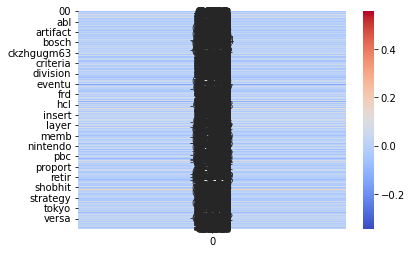

In [88]:
#Heatmap for correlation analysis of features
import seaborn as sns
import matplotlib.pyplot as plt

target_col = 'Job_Profile'
feature_cols = [col for col in train.columns if col != target_col]
feature_cols=feature_cols

# calculate the correlation between the target column and all other columns
corr = train[feature_cols].corrwith(train[target_col])

# create the heatmap using seaborn
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm')

# show the plot
plt.show()